### Modeling with Logistic Regression 

Goal: Classify magic cards by color using their text and logistic regression)

In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cross_validation import train_test_split, KFold, cross_val_score
import sklearn.metrics as sk

import pandas as pd
from collections import Counter
import numpy as np
import nltk

import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

In [2]:
modern = pd.read_pickle('data/5color_modern_no_name_hardmode.pkl')

In [3]:
Counter(modern.colors)

Counter({u'Black': 1576,
         u'Blue': 1573,
         u'Green': 1566,
         u'Red': 1575,
         u'White': 1584})

After all the data munging the classes are still amazingly balanced.

#### Lets single out blue and red for a binary classification


In [4]:
UG = modern.loc[modern['colors'].isin(['Blue', 'Red'])]

UG.reset_index(inplace=True)
UG.pop('index')

UG[['name', 'colors', 'cmc', 'text']].sample(6)

,name,colors,cmc,text
747,Goblin Rimerunner,Red,3.0,Tap : Target creature cant block this turn. {1...
968,Molten Disaster,Red,2.0,"Kicker {1} If This was kicked, it has split s..."
799,Draining Whelk,Blue,6.0,Flash Flying When This enters the battlefield...
2246,Vexing Devil,Red,1.0,"When This enters the battlefield, any opponent..."
1685,Hada Spy Patrol,Blue,2.0,Level up {2}{1} LEVEL 1-2 2/2 This cant be bl...
2832,Riverwheel Aerialists,Blue,6.0,Flying Prowess


In [5]:
dummies = pd.get_dummies(UG.colors)
# dummies['Green']

In [6]:
vectorizer = CountVectorizer()

vec_X = vectorizer.fit_transform(UG['text'])

X_train, X_test, y_train, y_test = train_test_split(vec_X, dummies['Red'],
                                             random_state=42)

print "There are {:,} words in the vocabulary.".format(len(vectorizer.vocabulary_))

There are 815 words in the vocabulary.


In [7]:
# Linear regression 
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
mses = cross_val_score(clf, X_train, y_train,
                       cv=10, scoring='mean_squared_error') * -1

acc = cross_val_score(clf, X_train, y_train,
                       cv=10, scoring='accuracy') 

print "MSE: %s, Accuracy: %s" % (mses.mean().round(3), acc.mean().round(3))

MSE: 0.094, Accuracy: 0.906


90% accuracy! these two colors were the ones I thought would be most different, but I never would have guessed they would be this easy to classify

#### Lets try naive bayes

In [8]:
# Multinomial naive bayes
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()

mses = cross_val_score(nb, X_train, y_train,
                       cv=10, scoring='mean_squared_error') * -1

acc = cross_val_score(nb, X_train, y_train,
                       cv=10, scoring='accuracy') 

print "MSE: %s, Accuracy: %s" % (mses.mean().round(3), acc.mean().round(3))

MSE: 0.133, Accuracy: 0.867


In [9]:
# Bernoulli naive bayes
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB()

mses = cross_val_score(bnb, X_train, y_train,
                       cv=10, scoring='mean_squared_error') * -1

acc = cross_val_score(bnb, X_train, y_train,
                       cv=10, scoring='accuracy') 

print "MSE: %s, Accuracy: %s" % (mses.mean().round(3), acc.mean().round(3))

MSE: 0.13, Accuracy: 0.87


Not as good as logistic regression

### Green vs All Five

The next step is separating green from a mix of all the colors

In [10]:
y = pd.get_dummies(modern.colors)['Green']

X = vectorizer.fit_transform(modern.text)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

print "There are {:,} words in the vocabulary.".format(len(vectorizer.vocabulary_))

There are 1,161 words in the vocabulary.


In [11]:
# Logistic regression 

from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver = 'lbfgs', multi_class='multinomial')

mses = cross_val_score(clf, X_train, y_train,
                       cv=10, scoring='mean_squared_error') * -1

acc = cross_val_score(clf, X_train, y_train,
                       cv=10, scoring='accuracy') 

print "MSE: %s, Accuracy: %s" % (mses.mean().round(3), acc.mean().round(3))

MSE: 0.137, Accuracy: 0.863


In [12]:
# Multinomial naive bayes

from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
mses = cross_val_score(nb, X_train, y_train,
                       cv=10, scoring='mean_squared_error') * -1

acc = cross_val_score(nb, X_train, y_train,
                       cv=10, scoring='accuracy') 

print "MSE: %s, Accuracy: %s" % (mses.mean().round(3), acc.mean().round(3))

MSE: 0.172, Accuracy: 0.828


# All Five Vs All Five

And now the main event. Five way classification of all the colors.

In [13]:
modern['bincolor'] = pd.Categorical.from_array(modern.colors).codes

In [14]:
vectorizer = CountVectorizer()

y = modern.bincolor

X = vectorizer.fit_transform(modern.text)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

print "There are {:,} words in the vocabulary.".format(len(vectorizer.vocabulary_))

There are 1,161 words in the vocabulary.


In [15]:
clf = LogisticRegression(C=2, multi_class='ovr', solver='liblinear')

mses = cross_val_score(clf, X_train, y_train,
                       cv=10, scoring='mean_squared_error') * -1

acc = cross_val_score(clf, X_train, y_train,
                       cv=10, scoring='accuracy') 

print "MSE: %s, Accuracy: %s" % (mses.mean().round(3), acc.mean().round(3))

MSE: 1.505, Accuracy: 0.702


70% Accuracy with one vs rest and multinomial. Different solvers changed processing time, but not accuracy.

Not bad for choosing one out of five categories, but can we improve it? 

First, what went wrong? 


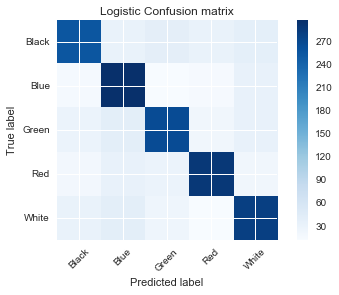

In [16]:
clf.fit(X_train, y_train)

label = ["Black", "Blue", "Green", "Red", "White"]

cm = sk.confusion_matrix(y_test, clf.predict(X_test), labels=None)

# plot code adapted from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

def plot_confusion_matrix(cm, title='Logistic Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    tick_marks = np.arange(len(label))
    plt.xticks(tick_marks, label, rotation=45)
    plt.yticks(tick_marks, label)    
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cm)   

Black and Green seem to be the colors hardest to classify. White and black seem to be the colors most often picked in error. 

In [25]:
def show_most_informative_features(vectorizor, clf, color=0, n=20):
    feature_names = vectorizor.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[color], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print "\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2)

show_most_informative_features(vectorizer, clf, color=0, n=20)

	-2.4766	vigilance      		4.1250	fear           
	-2.0944	gain           		3.7348	swamps         
	-2.0759	reach          		3.0854	discards       
	-1.8799	artifacts      		3.0126	sacrifices     
	-1.8680	attack         		2.7692	deathtouch     
	-1.8330	bloodrush      		2.7267	madness        
	-1.7888	enchantments   		2.6757	swampwalk      
	-1.7850	blocking       		2.6011	lose           
	-1.7180	having         		2.5120	rats           
	-1.6980	fights         		2.5012	nonblack       
	-1.6719	soldier        		2.3587	intimidate     
	-1.6326	draw           		2.2776	life           
	-1.6309	basic          		2.2034	delve          
	-1.6051	enchantment    		2.1743	zombie         
	-1.5909	base           		2.1421	loses          
	-1.5754	hands          		2.0499	black          
	-1.5337	aura           		2.0141	rogue          
	-1.4987	renown         		1.8897	phylactery     
	-1.4736	untap          		1.8737	extort         
	-1.4539	plains         		1.8734	theft          


In [37]:
for l in xrange(5):
    print label[l], 'most negative featues         top features '
    show_most_informative_features(vectorizer, clf, color=l, n=10)
    print '\n'

Black most negative featues         top features 
	-2.4766	vigilance      		4.1250	fear           
	-2.0944	gain           		3.7348	swamps         
	-2.0759	reach          		3.0854	discards       
	-1.8799	artifacts      		3.0126	sacrifices     
	-1.8680	attack         		2.7692	deathtouch     
	-1.8330	bloodrush      		2.7267	madness        
	-1.7888	enchantments   		2.6757	swampwalk      
	-1.7850	blocking       		2.6011	lose           
	-1.7180	having         		2.5120	rats           
	-1.6980	fights         		2.5012	nonblack       


Blue most negative featues         top features 
	-3.8806	haste          		3.0992	islandwalk     
	-3.5871	life           		2.8397	hands          
	-2.8945	destroy        		2.2837	draw           
	-2.4989	regenerate     		2.2035	draws          
	-2.4631	pays           		2.1987	landfall       
	-2.4530	reach          		2.0635	blocked        
	-2.2410	leaves         		2.0364	owners         
	-2.2384	long           		1.9954	trap           
	-2.1256	indestru

#### Without Commons

Commons are the most basic cards. Almost always they have the least text. Could accuracy be improved by skipping them? 

In [24]:
modern['bincolor'] = pd.Categorical.from_array(modern.colors).codes

a = modern.groupby('rarity').get_group('Uncommon')
b = modern.groupby('rarity').get_group('Rare')
c = modern.groupby('rarity').get_group('Mythic Rare')
no_commons = pd.concat([a,b,c])


no_commons['bincolor'] = pd.Categorical.from_array(no_commons.colors).codes

vectorizer = CountVectorizer()

y = no_commons.bincolor

X = vectorizer.fit_transform(no_commons.text)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

print "There are {:,} words in the vocabulary.".format(len(vectorizer.vocabulary_))

clf = LogisticRegression(C=2, multi_class='ovr', solver='liblinear')

mses = cross_val_score(clf, X_train, y_train,
                       cv=10, scoring='mean_squared_error') * -1

acc = cross_val_score(clf, X_train, y_train,
                       cv=10, scoring='accuracy') 

print "MSE: %s, Accuracy: %s" % (mses.mean().round(3), acc.mean().round(3))

There are 1,047 words in the vocabulary.
MSE: 1.669, Accuracy: 0.688


A slight decrease in accuracy, nothing to see here

###  Bayesian Ridge Regression

http://scikit-learn.org/stable/auto_examples/linear_model/plot_bayesian_ridge.html

In [6]:
modern['bincolor'] = pd.Categorical.from_array(modern.colors).codes

vectorizer = CountVectorizer()

y = modern.bincolor

X = vectorizer.fit_transform(modern.text)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

print "There are {:,} words in the vocabulary.".format(len(vectorizer.vocabulary_))

There are 1,161 words in the vocabulary.


In [37]:
from sklearn.linear_model import BayesianRidge, LinearRegression
import sklearn.metrics as sk

clf = BayesianRidge(compute_score=True)
clf.fit(X_train.toarray(), y_train)


print (sum(y_test == clf.predict(X_test).round()) * 1.0) /  len(y_test)

mse = cross_val_score(clf, X_train.toarray(), y_train,
                       cv=10, scoring='mean_squared_error') * -1
print np.mean(mse)

0.32656170645
1.32352266138


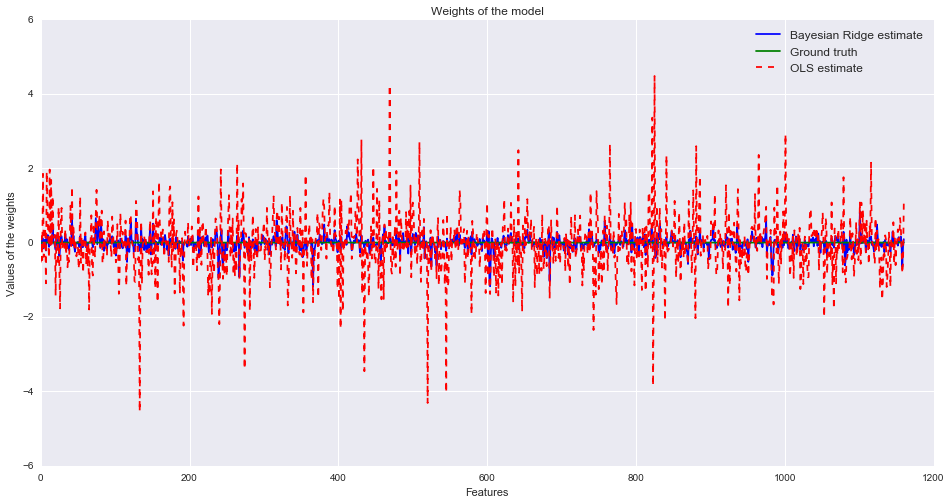

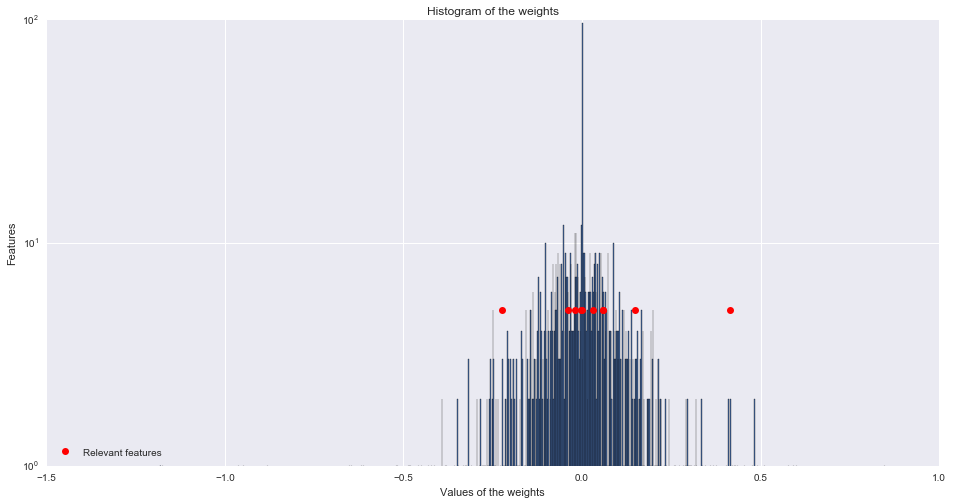

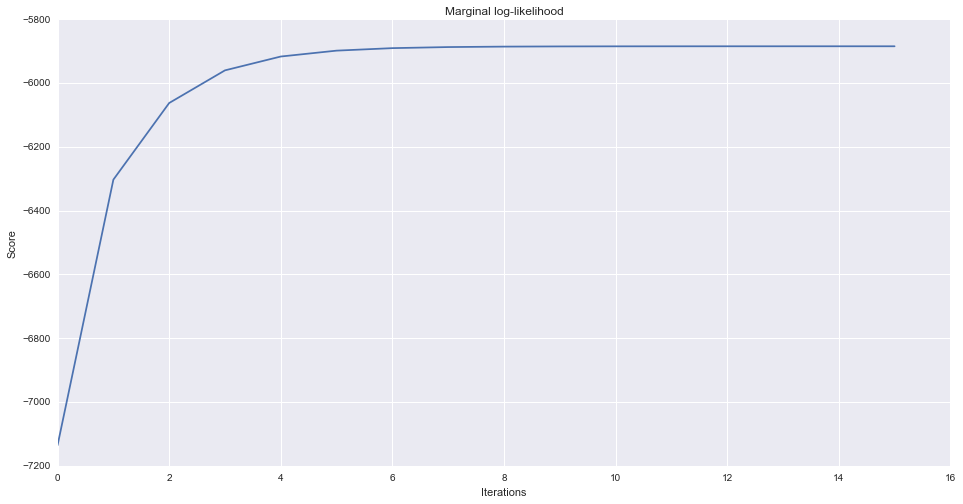

In [43]:
# Plot true weights, estimated weights and histogram of the weights

ols = LinearRegression()
ols.fit(X, y)

n_features = len(vectorizer.vocabulary_)
w = np.zeros(n_features)
relevant_features = np.random.randint(0, n_features, 10)

plt.figure(figsize=(16, 8))
plt.title("Weights of the model")
plt.plot(clf.coef_, 'b-', label="Bayesian Ridge estimate")
plt.plot(w, 'g-', label="Ground truth")
plt.plot(ols.coef_, 'r--', label="OLS estimate")
plt.xlabel("Features")
plt.ylabel("Values of the weights")
plt.legend(loc="best", prop=dict(size=12))

plt.figure(figsize=(16, 8))
plt.title("Histogram of the weights")
plt.hist(clf.coef_, bins=n_features, log=True)
plt.plot(clf.coef_[relevant_features], 5 * np.ones(len(relevant_features)),
         'ro', label="Relevant features")
plt.ylabel("Features")
plt.xlabel("Values of the weights")
plt.legend(loc="lower left")

plt.figure(figsize=(16, 8))
plt.title("Marginal log-likelihood")
plt.plot(clf.scores_)
plt.ylabel("Score")
plt.xlabel("Iterations")
plt.show()

### Just for Fun: Classification by Flavor Text

Some cards have text below their abilities with quotes and stories from the world. They have absolutely no effect on the game, but can be fun to read. Lets see if we can classify with them.

In [69]:
vectorizer = CountVectorizer(stop_words="english")

flavor_df = modern[pd.notnull(modern.flavor)]

y = flavor_df.bincolor

X = vectorizer.fit_transform(flavor_df.flavor)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

print "There are {:,} words in the vocabulary.".format(len(vectorizer.vocabulary_))

There are 10,767 words in the vocabulary.


In [70]:
clf = LogisticRegression(C=1)

mses = cross_val_score(clf, X_train, y_train,
                       cv=10, scoring='mean_squared_error') * -1

acc = cross_val_score(clf, X_train, y_train,
                       cv=10, scoring='accuracy') 

print "MSE: %s, Accuracy: %s" % (mses.mean().round(3), acc.mean().round(3))

MSE: 2.395, Accuracy: 0.54


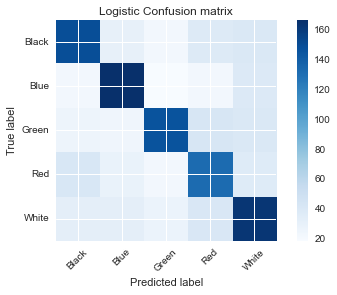

In [71]:
clf.fit(X_train, y_train)

cm = sk.confusion_matrix(y_test, clf.predict(X_test), labels=None)

plot_confusion_matrix(cm)  

In [73]:
show_most_informative_features(vectorizer, clf)

	-1.3655	nature         		1.9806	liliana        
	-1.1212	flame          		1.6831	swamp          
	-1.1140	forest         		1.6378	sheoldred      
	-1.1099	goblin         		1.6215	dark           
	-1.0553	people         		1.5893	silumgar       
	-0.9955	times          		1.5846	weak           
	-0.9814	glory          		1.5644	victims        
	-0.9562	rage           		1.5617	rats           
	-0.9338	safety         		1.5003	death          
	-0.9312	easy           		1.4906	pharika        
	-0.9039	goblins        		1.4846	nightmares     
	-0.9023	sky            		1.4718	geth           
	-0.8970	want           		1.4278	undeath        
	-0.8761	kithkin        		1.4015	feast          
	-0.8717	ground         		1.3849	dead           
	-0.8703	defend         		1.3560	victim         
	-0.8622	home           		1.3455	cruelty        
	-0.8578	enemies        		1.3351	dimir          
	-0.8558	dragon         		1.3180	grave          
	-0.8523	wolf           		1.3102	vile           
	-0.8440	song       

Much larger vocabulary size and 50% accuracy. Quite surprising. 

In [1]:
# Todo: add softmax

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x)/(sum(np.exp(x)))
